In [247]:
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import os

from collections import namedtuple
from scipy.signal import find_peaks


TARGET_DIR = "segmented_digits/"
AUDIO_DIR = "audios/"  # each person audios should be stored inside its own directory
SPEECH_THRESHOLD = 0.05  # threshold to consider a frame as speech based on energy
DISPERSION = 0.5  # minimum separation in seconds between two peaks to be considered different digits


Signal = namedtuple("Signal", ["y", "fs", "file"])


def signal_from_file(filename):
    fs, y = wav.read(filename)
    y = y / 2**15

    return Signal(y, fs, os.path.basename(filename))


def plot_signal(y, fs, title, peaks=None, hlines=None, vlines=None):
    t = np.arange(len(y)) / fs
    plt.plot(t, y)

    if peaks is not None:
        plt.plot(peaks / fs, y[peaks], "x")

    if hlines is not None:
        for y in hlines:
            plt.axhline(y, color="r", linestyle="--")

    if vlines is not None:
        for x in vlines:
            plt.axvline(x, color="r", linestyle="--")

    plt.xlabel("Time (s)")
    plt.title(title)
    plt.show()


def non_overlapping_frames(signal, frame_duration):
    frame_len = round(frame_duration * signal.fs)
    total_frames = len(signal.y) // frame_len

    frames = signal.y[: total_frames * frame_len]
    frames = frames.reshape(frame_len, total_frames, order="F")

    return frames


Processing test_0.wav from test_1



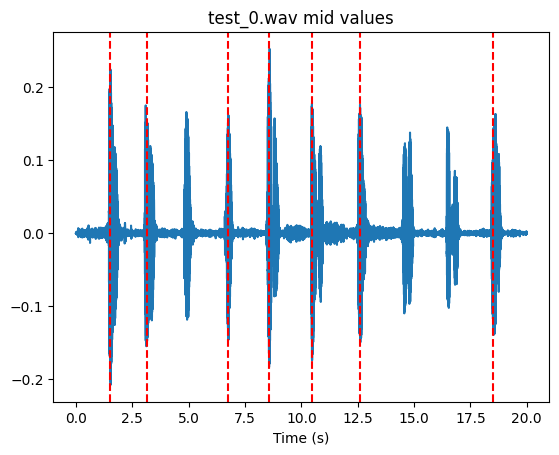


Processing mi_sonido.wav from test_2



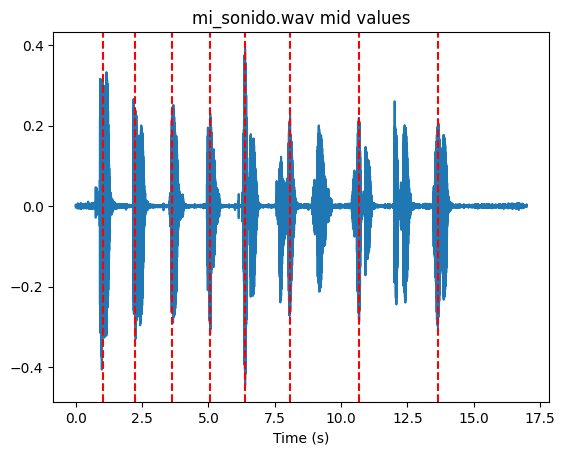

In [248]:
for person_id, directory in enumerate(os.listdir(AUDIO_DIR)):
    dir_path = os.path.join(AUDIO_DIR, directory)

    for record_id, file in enumerate(os.listdir(dir_path)):

        print()
        print("=======================================================================")
        print(f"Processing {file} from {directory}")
        print("=======================================================================")
        print()

        signal_path = os.path.join(dir_path, file)

        signal = signal_from_file(signal_path)
        # plot_signal(signal.y, signal.fs, title=signal.file)

        frame_duration = 0.02
        frames = non_overlapping_frames(signal, frame_duration)
        frame_len, total_frames = frames.shape
        frames_fs = 1 / frame_duration

        energy_frames = np.sum(frames**2, axis=0)
        energy_peaks, _ = find_peaks(
            energy_frames, height=SPEECH_THRESHOLD * np.max(energy_frames)
        )

        last_peak = energy_peaks[0]
        current_peaks = []
        energy_mid_values = []
        dispersion = []
        for peak in energy_peaks:
            if peak - last_peak < DISPERSION * frames_fs:
                current_peaks.append(peak)
            else:
                energy_mid_values.append(np.mean(current_peaks))
                current_peaks = [peak]

            last_peak = peak

        energy_mid_values.append(np.mean(current_peaks))

        energy_mid_values = np.array(energy_mid_values).astype(int)
        signal_mid_values = np.array(energy_mid_values / frames_fs)

        # plot_signal(
        #     energy_frames,
        #     frames_fs,
        #     title=f"Energy {signal.file} peaks",
        #     hlines=[SPEECH_THRESHOLD * np.max(energy_frames)],
        #     peaks=energy_peaks,
        # )

        # plot_signal(
        #     energy_frames,
        #     frames_fs,
        #     title=f"Energy {signal.file} mid values",
        #     peaks=energy_mid_values,
        # )

        # vlines = np.array(
        #     [((value - 0.5), (value + 0.5)) for value in signal_mid_values]
        # )
        # plot_signal(
        #     signal.y,
        #     signal.fs,
        #     title=f"{signal.file} speech segments",
        #     vlines=vlines.flatten(),
        # )

        plot_signal(
            signal.y,
            signal.fs,
            title=f"{signal.file} mid values",
            vlines=signal_mid_values,
        )

        digits_name_dict = {
            0: "cero",
            1: "uno",
            2: "dos",
            3: "tres",
            4: "cuatro",
            5: "cinco",
            6: "seis",
            7: "siete",
            8: "ocho",
            9: "nueve",
        }

        empty_signal_duration = 0.5
        empty_signal_len = round(empty_signal_duration * signal.fs)
        empty_signal = np.zeros(empty_signal_len)

        for i, value in enumerate(signal_mid_values):
            speech_start = round((value - 0.5) * signal.fs)
            speech_end = round((value + 0.5) * signal.fs)
            speech = np.concatenate(
                [empty_signal, signal.y[speech_start:speech_end], empty_signal]
            )

            digit_name = digits_name_dict[i]
            # plot_signal(speech, signal.fs, title=f"{signal.file} {digit_name}")

            digit_path = os.path.join(
                TARGET_DIR, f"{digit_name}_{person_id + 1}_{record_id + 1}.wav"
            )

            if os.path.exists(digit_path):
                os.remove(digit_path)

            # wav.write(digit_path, signal.fs, speech)